In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import requests
from datetime import datetime

## Timespan (30days, 60days, 180days, 1year, 2years, all)
start = '2010-12-10'
##Open data
data = pd.read_csv('https://community-api.coinmetrics.io/v2/assets/btc/metricdata.csv?metrics=PriceUSD,CapMrktCurUSD,CapRealUSD,TxTfrValAdjUSD,IssContNtv,SplyCur&start='+start, index_col = 0, parse_dates=True)

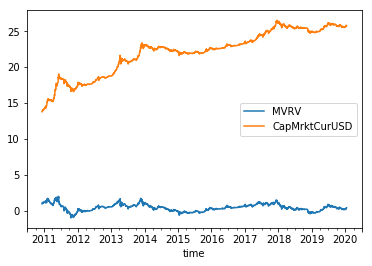

In [2]:
## MVRV

## MVRV Ratio
data['MVRV'] = data['CapMrktCurUSD'] / data['CapRealUSD']
## MVRV-z
per = 30
data['MVRV-z'] = (data['MVRV'] - data['MVRV'].rolling(per).mean()) / data['MVRV'].rolling(per).std()

## Chart
np.log(data[['MVRV', 'CapMrktCurUSD']]).plot()

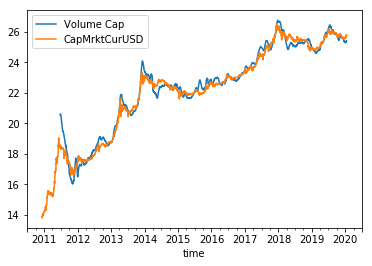

In [3]:
## NVT

## NVT Ratio
per = 90
data['NVT'] = data['CapMrktCurUSD'] / data['TxTfrValAdjUSD'].rolling(per).mean()
## Volume Cap
per1 = 20
data['Volume Cap'] = (data['NVT'].rolling(per).mean() * data ['TxTfrValAdjUSD']).rolling(per1).mean()
## Deviation
data['Dev Vol Cap'] = (data['Volume Cap'] - data['CapMrktCurUSD']) / data['CapMrktCurUSD']

## Chart
np.log(data[['Volume Cap', 'CapMrktCurUSD']]).plot()

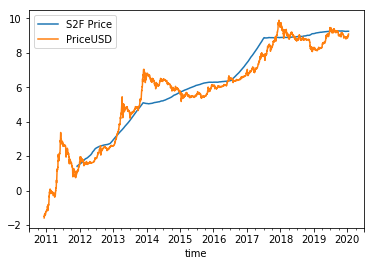

In [4]:
## Stock-to-Flow

## S2F Ratio
data['S2F'] = data['SplyCur'] / data['IssContNtv'].rolling(360).sum()
## S2F Price
data['S2F Price'] = np.exp(-1.84) * data['S2F'] ** 3.36
## S2F 360d discounting Satoshi's tokens (1MM BTC)
data['disc S2F'] = (data['SplyCur'] - 1000000) / data['IssContNtv'].rolling(360).sum()
## Deviation
data['Dev S2F'] = (data['S2F Price'] - data['PriceUSD']) / data['PriceUSD']

## Chart
np.log(data[['S2F Price', 'PriceUSD']]).plot()

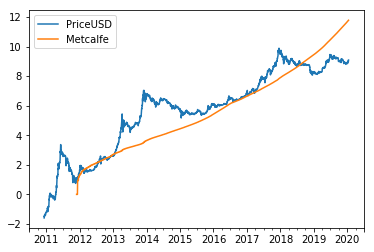

In [5]:
## Metcalfe's Law

## Blockchain.com wallets data
timespan = 'all'
w_data = pd.read_csv('https://api.blockchain.info/charts/my-wallet-n-users?timespan='+timespan+'&format=csv', header=None, infer_datetime_format =True)
w_data.columns = ['Date', 'nWallets']
## Parsing date
w_data['Date'] = w_data['Date'].apply(lambda x: datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
## Eliminate 'intra day' data
w_data['Date'] = w_data['Date'].drop_duplicates(keep = 'last')
w_data = w_data[w_data['Date'].notnull()]
## Date to index
w_data.set_index('Date', inplace=True, drop=True)

## Merge dataframes
data = pd.concat([data, w_data], axis=1, sort=True, join='outer')
## Fill empty cells
data['nWallets'] = data['nWallets'].ffill(axis = 0)
## Transaction pairs (mil)
data['Tx Pairs'] = data['nWallets'] * (data['nWallets'] - 1) / 2
## Gompertz Sigmoid
data['G_Sigmoid'] = data['SplyCur'] * np.log(21000000 / data['SplyCur'])
## Metcalfe value
a = 900000
data['Metcalfe (log)'] = a * np.log(data['Tx Pairs']) / data['G_Sigmoid']
data['Metcalfe'] = np.exp(data['Metcalfe (log)'])
## Deviation
data['Dev Metcalfe'] = (data['Metcalfe'] - data['PriceUSD']) / data['PriceUSD']

## Chart

np.log(data[['PriceUSD', 'Metcalfe']]).plot()

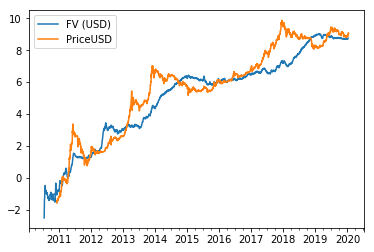

In [7]:
## Quantity Theory of Money

fv = pd.read_csv('Desktop/Monografia/fv_bitcoin_usd.csv', parse_dates=True)

## Parsing date
fv['DateTime'] = fv['DateTime'].apply(lambda x: datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
## Date to index
fv.set_index('DateTime', inplace=True, drop=True)
## Merge dataframes
#data = pd.concat([data, fv], axis=1, sort=True, join='outer')
## Fixing dates
data['FV (USD)'] = pd.to_numeric(data['FV (USD)'], errors='coerce')
## Deviation
data['Dev FV'] = (data['FV (USD)'] - data['PriceUSD']) / data['PriceUSD']

## Chart
np.log(data[['FV (USD)', 'PriceUSD']]).plot()

In [18]:
## Defining events
# Start
ev0 = '2011-06-01'
# Mt. Gox hack
ev1 = '2014-02-07'
# 2015 bottom to reversal
ev2 = '2015-08-24'
# CME futures
ev3 = '2017-12-18'

## Sectioning by date
alltime = data[(data.index > ev0)]
age1 = data[(data.index > ev0) & (data.index <= ev1)]
age2 = data[(data.index > ev1) & (data.index <= ev2)]
age3 = data[(data.index > ev2) & (data.index <= ev3)]
age4 = data[data.index > ev3]

## Ages
ages = [alltime, age1, age2, age3, age4]
ages_names = ['all time', 'Genesis - Mt. Gox hack', 'Mt.Gox hack - 2015 bottom', '2015 bottom - CME futures', 'CME futures - now']

age2

,PriceUSD,CapMrktCurUSD,CapRealUSD,TxTfrValAdjUSD,IssContNtv,SplyCur,MVRV,MVRV-z,NVT,Volume Cap,...,G_Sigmoid,Metcalfe (log),Metcalfe,Dev Metcalfe,FV (USD),P (USD),FVU (USD) (low),FVU (USD) (high),P/FV,Dev FV
2014-02-08,677.682301,8.384312e+09,3.885018e+09,1.282378e+08,4550.0,1.237204e+07,2.158114,-2.765720,40.508068,1.181826e+10,...,6.545840e+06,3.753907,42.687545,-0.937010,124.630838,677.682304,92.314241,168.260560,5.437517,-0.816093
2014-02-09,687.406055,8.506987e+09,3.888063e+09,1.093370e+08,3450.0,1.237549e+07,2.187975,-2.324287,41.047608,1.170930e+10,...,6.544215e+06,3.754839,42.727358,-0.937843,124.284729,687.406055,91.418119,168.967531,5.530897,-0.819198
2014-02-10,685.457499,8.485546e+09,3.890732e+09,1.753455e+08,3900.0,1.237939e+07,2.180964,-2.190279,40.805514,1.168285e+10,...,6.542377e+06,3.755894,42.772460,-0.937600,126.197861,685.457499,94.439486,168.636031,5.431609,-0.815893
2014-02-11,671.899692,8.320463e+09,3.889298e+09,1.534398e+08,4100.0,1.238349e+07,2.139322,-2.148812,39.990631,1.167889e+10,...,6.540443e+06,3.757005,42.819987,-0.936270,128.426069,671.899692,96.705589,170.551209,5.231801,-0.808861
2014-02-12,653.765781,8.098811e+09,3.886174e+09,1.130948e+08,4450.0,1.238794e+07,2.084006,-2.137664,39.028475,1.155710e+10,...,6.538343e+06,3.758212,42.871701,-0.934423,128.851638,653.765781,97.127693,170.937291,5.073787,-0.802909
2014-02-13,612.918415,7.595524e+09,3.884317e+09,1.003994e+08,4450.0,1.239239e+07,1.955433,-2.342933,36.659520,1.122411e+10,...,6.536241e+06,3.759421,42.923549,-0.929969,131.568616,612.918415,99.457922,174.046475,4.658546,-0.785341
2014-02-14,668.788603,8.291083e+09,3.892561e+09,1.249835e+08,4775.0,1.239716e+07,2.129981,-1.537099,40.001058,1.122357e+10,...,6.533983e+06,3.760719,42.979336,-0.935736,135.162283,668.788603,102.742289,177.812301,4.948042,-0.797900
2014-02-15,654.377060,8.115479e+09,3.894776e+09,1.112291e+08,4675.0,1.240184e+07,2.083683,-1.579106,39.208534,1.109321e+10,...,6.531771e+06,3.761993,43.034106,-0.934237,135.072521,654.377060,104.953444,173.835038,4.844635,-0.793586
2014-02-16,623.250322,7.732489e+09,3.895289e+09,1.325357e+08,4875.0,1.240671e+07,1.985087,-1.769623,37.756705,1.083269e+10,...,6.529463e+06,3.776019,43.641970,-0.929977,134.057046,623.250322,104.210228,172.452281,4.649143,-0.784907
2014-02-17,631.334596,7.835235e+09,3.895107e+09,1.383360e+08,3875.0,1.241059e+07,2.011558,-1.543801,38.662269,1.064185e+10,...,6.527627e+06,3.777082,43.688352,-0.930800,134.542502,631.334596,103.434050,175.007019,4.692455,-0.786892


In [19]:
## Test for each metric
testNVT = pd.DataFrame()
testS2F = pd.DataFrame()
testMetcalfe = pd.DataFrame()
testFV = pd.DataFrame()

tests = [testNVT, testS2F, testMetcalfe, testFV]
metrics_dev = [data['Dev Vol Cap'], data['Dev S2F'], data['Dev Metcalfe'], data['Dev FV']]

for n in range(len(metrics_dev)):
    for i in range(len(ages)):
        data = ages[i]
        metric_dev = metrics_dev[n]
        tests[n].at[i, 0] = ages_names[i]
        ## Fill test dataframe
        tests[n].at[i, '0 - 0.2'] = ((abs(metric_dev) <= 0.2).sum() / len(metric_dev)).round(2)
        tests[n].at[i, '0.2 - 0.5'] = ((metric_dev[(abs(metric_dev) <= 0.5) & (abs(metric_dev) > 0.2)].count() / len(metric_dev))).round(2)
        tests[n].at[i, '0.5 - 1.0'] = ((metric_dev[(abs(metric_dev) <= 1) & (abs(metric_dev) > 0.5)].count()) / len(metric_dev)).round(2)
        tests[n].at[i, '1.0 - ...'] = (metric_dev[(abs(metric_dev) > 1)].count() / len(metric_dev)).round(2)
        tests[n].at[i, 'Max dev'] = metric_dev.max().round(2)
        tests[n].at[i, 'Min dev'] = metric_dev.min().round(2)
        print(i, n)

data = alltime
    
#testFV #, testS2F, testMetcalfe, testFV)

testS2F

0 0
1 0
2 0
3 0
4 0
0 1
1 1
2 1
3 1
4 1
0 2
1 2
2 2
3 2
4 2
0 3
1 3
2 3
3 3
4 3


,0,0 - 0.2,0.2 - 0.5,0.5 - 1.0,1.0 - ...,Max dev,Min dev
0,all time,0.19,0.34,0.28,0.13,2.71,-0.86
1,Genesis - Mt. Gox hack,0.19,0.34,0.28,0.13,2.71,-0.86
2,Mt.Gox hack - 2015 bottom,0.19,0.34,0.28,0.13,2.71,-0.86
3,2015 bottom - CME futures,0.19,0.34,0.28,0.13,2.71,-0.86
4,CME futures - now,0.19,0.34,0.28,0.13,2.71,-0.86


In [ ]:
## Gráficos

fig, (ax1) = plt.subplots()
fig.suptitle('S2F x PriceUSD')
ax1.scatter(np.log(data['S2F_360d']), np.log(data['PriceUSD']))

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Market Cap x NVT')
ax1.plot(data.index, np.log(data['PriceUSD']))
ax2.plot(data.index, np.log(data['S2F Price']))

#data[['CapMrktCurUSD', 'Volume Cap']].plot(linewidth=2, markersize=50)
plt.show()